## Recommendation system



In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/demographic.csv")
df.head()


,title,genres,runtime,vote_average,vote_count,release_year,Action,Adventure,Animation,Comedy,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Toy Story,Animation; Comedy; Family,81.0,7.7,5415.0,1995,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,Adventure; Fantasy; Family,104.0,6.9,2413.0,1995,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,Romance; Comedy,101.0,6.5,92.0,1995,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,Waiting to Exhale,Comedy; Drama; Romance,127.0,6.1,34.0,1995,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,Father of the Bride Part II,Comedy,106.0,5.7,173.0,1995,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
class RecomenderSystemDF:
    def __init__(self, data):
        self.df = pd.read_csv(data)
        
    def recommendDF(self, genre=None, duration=None, year=None, topk=10):
        df = self.df.copy()
        df = self.demographic_filter(df, genre=genre, duration=duration, year=year)
        df = self.compute_imdb_score(df)
        result = df.loc[:, "title":"release_year"]
        result = result.sort_values("vote_average", ascending=False)
        result = result.head(topk)
        return result
    
    @staticmethod    
    def demographic_filter(df, genre=None, duration=None, year=None):
        df = df.copy()
        
        if genre is not None:
            df = df[df[genre].all(axis=1)]
        if duration is not None:
            df = df[df.runtime.between(duration[0], duration[1])]
        if year is not None:
            df = df[df.release_year.between(year[0], year[1])]
        return df
    
    @staticmethod
    def compute_imdb_score(df, q=0.8):
        df = df.copy()
        
        m = df.vote_count.quantile(q)
        C = (df.vote_average * df.vote_count).sum() / df.vote_count.sum()

        df = df[df.vote_count >= m] 
        df["score"] = df.apply(lambda x: (x.vote_average * x.vote_count + C*m) / (x.vote_count + m), axis=1) 
        return df
        
  

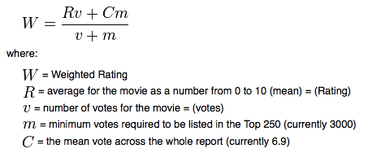

In [19]:
from IPython.display import Image

Image("data/imdb.png")

In [20]:
recsys = RecomenderSystemDF(data="data/demographic.csv")

In [21]:
recsys.recommendDF(genre=["Animation"], duration=(60, 150), year=(2015, 2020), topk=10)

,title,genres,runtime,vote_average,vote_count,release_year
40018,Your Name.,Romance; Animation; Drama,106.0,8.5,1030.0,2016
30208,Inside Out,Drama; Comedy; Animation; Family,94.0,7.9,6737.0,2015
39787,Kubo and the Two Strings,Animation; Adventure; Family,102.0,7.7,982.0,2016
36082,Zootopia,Animation; Adventure; Family; Comedy,108.0,7.7,4961.0,2016
33181,The Little Prince,Adventure; Animation; Fantasy,92.0,7.6,771.0,2015
41203,Moana,Adventure; Animation; Family,107.0,7.3,3471.0,2016
41714,The Lego Batman Movie,Action; Animation; Comedy; Family; Fantasy,104.0,7.2,1473.0,2017
29061,Shaun the Sheep Movie,Family; Animation; Comedy; Adventure,85.0,6.9,456.0,2015
31900,Anomalisa,Animation; Comedy; Drama; Romance,90.0,6.9,472.0,2015
28702,Home,Fantasy; Comedy; Animation; Science Fiction; F...,94.0,6.8,1539.0,2015


# Recommender with content based filtering

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_distances

In [14]:
df = pd.read_csv("data/content_by_synopsis.csv")
df.head()

,title,overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [16]:
class RecommenderSystemCBF:
    def __init__(self, data, content_col):
        self.df = pd.read_csv(data)
        self.content_col = content_col
        self.encoder = None
        self.bank = None
        
    def fit_cbf(self):
        self.encoder = CountVectorizer(stop_words="english", tokenizer=word_tokenize)
        self.bank = self.encoder.fit_transform(self.df[self.content_col])
        
    def recommend_cbf(self, idx, topk=10): 
        content = df.loc[idx, self.content_col]
        code = self.encoder.transform([content])
        dist = cosine_distances(code, self.bank)
        rec_idx = dist.argsort()[0, 1:(topk+1)]
        return self.df.loc[rec_idx]

In [17]:
recsys = RecommenderSystemCBF("data/content_by_synopsis.csv", content_col="overview")
recsys.fit_cbf()

In [18]:
recsys.recommend_cbf(3) 

,title,overview
37288,The Cheetah Girls 2,"Best friends Galleria, Chanel, Dorinda, and Aq..."
12257,Young People Fucking,"On a Tuesday night, five couples have separate..."
14784,Fat People,"""GORDOS"" is a comedy about life's excesses and..."
32520,David Bowie: Best Of Bowie,"Disc 1: Oh. You Pretty Things, Queen Bitch), F..."
24144,A Summer in St. Tropez,In an isolated country house close to the shor...
4849,Little Dieter Needs to Fly,"In 1966, Dieter Dengler was shot down over Lao..."
8091,Secret Honor,"In this speculative one-man drama, we see form..."
4876,Going Places,"Two whimsical, aimless thugs harass and assaul..."
765,My Life and Times With Antonin Artaud,"May, 1946, in Paris young poet Jacques Prevel ..."
19253,We the Party,"In Los Angeles, five high-school friends deal ..."


In [19]:
df = pd.read_csv("data/collaborative_filtering.csv")
df.head()

,userId,movie,rating
0,1,One Flew Over the Cuckoo's Nest (1975),5
1,1,James and the Giant Peach (1996),3
2,1,My Fair Lady (1964),3
3,1,Erin Brockovich (2000),4
4,1,"Bug's Life, A (1998)",5


In [20]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [21]:
class RecommenderSystemCF:
    def __init__(self, data):
        self.df = pd.read_csv(data)
        self.all_movies = self.df.movie.unique()
        self.model = None
        
    def fit_cf(self):
        data = Dataset.load_from_df(self.df, Reader())
        trainset = data.build_full_trainset()
        self.model = SVD()
        self.model.fit(trainset)
        
    def recommend_cf(self, user_id, topk=10):
        watched = self.df[self.df.userId == user_id].movie
        not_watched = [movie for movie in self.all_movies if movie not in watched]
        score = [self.model.predict(user_id, movie).est for movie in not_watched]
        
        result = pd.DataFrame({"movie": not_watched, "pred_score":score})
        result.sort_values("pred_score", ascending=False, inplace=True)
        return result.head(topk)

In [22]:
recsys = RecommenderSystemCF("data/collaborative_filtering.csv")
recsys.fit_cf()

In [23]:
recsys.recommend_cf(user_id=1)

,movie,pred_score
167,"Shawshank Redemption, The (1994)",4.964260
9,"Wizard of Oz, The (1939)",4.812836
2617,Sanjuro (1962),4.812175
669,"Godfather, The (1972)",4.801132
0,One Flew Over the Cuckoo's Nest (1975),4.795462
47,To Kill a Mockingbird (1962),4.745363
23,Schindler's List (1993),4.737679
505,Life Is Beautiful (La Vita � bella) (1997),4.719146
92,Braveheart (1995),4.699186
420,Casablanca (1942),4.690033
